In [1]:
import random
import torch
import d2l
import numpy as np
import matplotlib.pyplot as plt
from torch import autograd
import warnings
warnings.filterwarnings("ignore")

/home/jovyan/work/d2l/notebooks/d2l.py:119: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self, 'net'), 'Neural network is defined'
/home/jovyan/work/d2l/notebooks/d2l.py:123: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self, 'trainer'), 'trainer is not inited'


# 3.4.6. Exercises

## 1. What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we initialized the parameters with variance 1000 rather than 0.1?

### origin model(initialize the weights with norm(0,0.01))

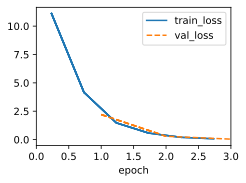

In [7]:
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
model = d2l.LinearRegressScratch(2, lr=0.03)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model,data)

### Initialize the weights with zero

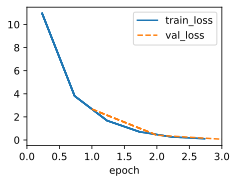

In [5]:
model = d2l.LinearRegressScratch(2, lr=0.03,sigma = 0)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model,data)

### Initialize the weights with norm(0,1000)

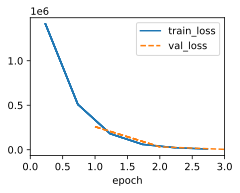

In [6]:
model = d2l.LinearRegressScratch(2, lr=0.03,sigma=1000)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model,data)

## 2. Assume that you are Georg Simon Ohm trying to come up with a model for resistors that relate voltage and current. Can you use automatic differentiation to learn the parameters of your model?

In this context, starting from Ohm's Law, it is understood that the current passing through a resistor is directly proportional to the voltage applied:
$$
V = I \cdot R 
$$


Where:
* $V$ represents voltage
* $I$ represents current
* $R$ represents resistance

So we generate synthetic data $V$ and $I$ with a parameter $R$ and build a line regression model to simulate the relationship between voltage and current. Meanwhile MSE is employed as the loss function to quantify the difference between predicted and actual voltages. Utilizing the stochastic gradient descent (SGD) optimizer, a training loop encompasses forward and backward propagation, as well as parameter updates. As training progresses, the model gradually adjusts the value of parameter $R$, allowing the predicted voltage to approach the actual voltage.

In [2]:
data = d2l.SyntheticRegressionData(w=torch.tensor([5.1]), b=0, noise=1)
model = d2l.LinearRegressScratch(1, lr=0.03)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model,data)

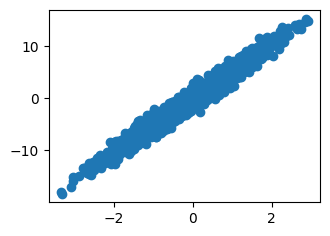

In [3]:
plt.figure(figsize=(3.5, 2.5))
plt.scatter(data.X, data.y)
plt.show()

In [29]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([0.3010], grad_fn=<SubBackward0>)
error in estimating b: tensor([-0.0321], grad_fn=<RsubBackward1>)


## 3. Can you use [Planck’s Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object using spectral energy density? For reference, the spectral density of radiation emanating from a black body is 
$$
B(\lambda, T)=\frac{2 h c^2}{\lambda^5} \cdot\left(\exp \frac{h c}{\lambda k T}-1\right)^{-1}
$$

Here 
* $\lambda$ is the wavelength
* $T$ is the temperature 
* $c$ is the speed of light 
* $h$ is Planck’s quantum 
* $k$ is the Boltzmann constant

You measure the energy for different wavelengths $\lambda$ and you now need to fit the spectral density curve to Planck’s law.

In [5]:
def f(t, x):
    c = 299792458
    h = 6.6260701e-34
    k = 1.380649e-23
    beta = h*c/(k*x)
    alpha = 2*h*c**2/x**5
    return alpha/(torch.exp(beta/t)-1)

class SyntheticPlankData(d2l.DataModule):
    def __init__(self, T, noise=0.05, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.arange(300, n) * 1e-9
        noise = random.random() * noise
        self.y = f(T, self.X)*(1+noise)
        
    def get_tensorloader(self, tensor, train, indices=slice(0, None)):
        tensor = tuple(a[indices] for a in tensor)
        dataset = torch.utils.data.TensorDataset(*tensor)
        return torch.utils.data.DataLoader(dataset, self.batch_size,
                                           shuffle=train)

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)


class PlankModel(d2l.Module):
    def __init__(self, T, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        # self.T = torch.normal(0, sigma, (1,), requires_grad=True) * 4500
        self.T = torch.Tensor([T])
        self.T.requires_grad = True

    def forward(self, X):
        return f(self.T, X)

    def loss(self, y_hat, y):
        l = (y_hat-y)**2/2
        return l.mean()

    def configure_optimizers(self):
        return d2l.SGD([self.T], self.lr)

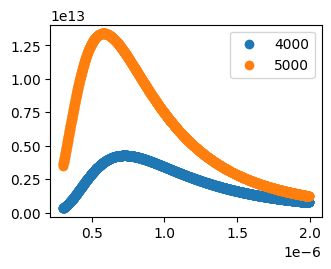

In [7]:
ts = [4000, 5000]
datas = []
plt.figure(figsize=(3.5, 2.5))
for t in ts:
    datas.append(SyntheticPlankData(t))
    plt.scatter(datas[-1].X, datas[-1].y, label=t)
plt.legend()
plt.show()

tensor([5054.9624], requires_grad=True)

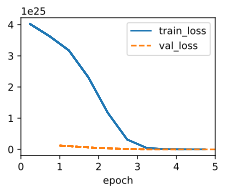

In [20]:
data = SyntheticPlankData(5020)
model = PlankModel(T=3000, lr=1e-21)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)
model.T

## 4. What are the problems you might encounter if you wanted to compute the second derivatives of the loss? How would you fix them?

use `autograd.grad` with `create_graph=True`

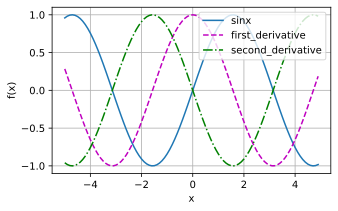

In [6]:
def sin(x):
    return torch.sin(x)


x = torch.arange(-5, 5, 0.1)
x.requires_grad = True
y = sin(x)
first_derivative = autograd.grad(y.sum(), x, create_graph=True)[0]
second_derivative = autograd.grad(first_derivative.sum(), x)[0]
d2l.plot(x.detach(), [sin(x).detach(), first_derivative.detach(),
                      second_derivative.detach()], 'x', 'f(x)',
         figsize=(5, 3), legend=['sinx', 'first_derivative',
                                 'second_derivative'])

## 5. Why is the reshape method needed in the loss function?

Reshaping is used to ensure that the dimensions of the predicted values match the dimensions of the ground truth values so that the loss calculation can be performed correctly.

## 6. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the error by increasing the number of epochs of training?

We make some experienmts with lr in [0.003,0.03,0.3,3] with `epoch=3`
* when lr is small (such as 0.003), the loss function drops very slow, and the error can be reduced by increasing epoch
* when lr increases, the loss function drops faster, and if it convergences, increasing epoch will not help too.
* when lr is much larger (such as 3), the loss function blows up, and there is no need to increase epoch

### lr = 0.003, epoch = 3

(tensor([[ 0.4372],
         [-0.8910]], requires_grad=True),
 tensor([1.0680], requires_grad=True))

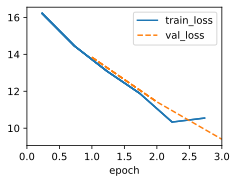

In [12]:
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
model = d2l.LinearRegressScratch(2, lr=0.003)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model,data)
model.w,model.b

### lr = 0.003, epoch = 10

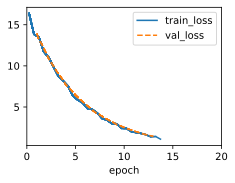

In [ ]:
model = d2l.LinearRegressScratch(2, lr=0.003)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model,data)
model.w,model.b

### lr = 0.03, epoch = 3

(tensor([[ 1.8396],
         [-3.2372]], requires_grad=True),
 tensor([3.9771], requires_grad=True))

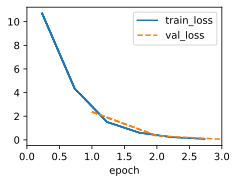

In [13]:
model = d2l.LinearRegressScratch(2, lr=0.03)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model,data)
model.w,model.b

### lr = 0.3, epoch = 3

(tensor([[ 2.0009],
         [-3.3990]], requires_grad=True),
 tensor([4.1986], requires_grad=True))

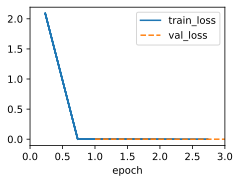

In [14]:
model = d2l.LinearRegressScratch(2, lr=0.3)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model,data)
model.w,model.b

### lr = 3, epoch = 3

(tensor([[-3.2974e+29],
         [ 4.5504e+29]], requires_grad=True),
 tensor([-7.8700e+28], requires_grad=True))

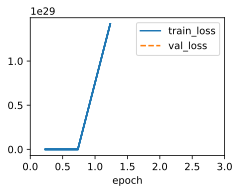

In [15]:
model = d2l.LinearRegressScratch(2, lr=3)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model,data)
model.w,model.b

## 7. If the number of examples cannot be divided by the batch size, what happens to data_iter at the end of an epoch?

We add codes below in `function fit_epoch`

```python
if len(batch[0]) != 32:
    print(len(batch[0]))
```
As the result print 3 times(which equals `max_epochs`) of 8(which equals `1000 - 32*1000//32`), we may make the conclusion that the last data_iter will give out all the examples left even though the number of examples is less than the batch size. 
We can also set parameter `drop_last=True` of `DataLoader`, if we just want to ignore the batch whose size is smaller than others.

In [2]:
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
model = d2l.LinearRegressScratch(2, lr=0.03)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

8
8
8


## 8. Try implementing a different loss function, such as the absolute value loss (y_hat - d2l.reshape(y, y_hat.shape)).abs().sum().
* Check what happens for regular data.
* Check whether there is a difference in behavior if you actively perturb some entries, such as $y_5=10000$ of $y$
* Can you think of a cheap solution for combining the best aspects of squared loss and absolute value loss? Hint: how can you avoid really large gradient values?

In [2]:
class LinearRegressAbsLoss(d2l.Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)
        
    def forward(self, X):
        return torch.matmul(X, self.w) + self.b
    
    def loss(self, y_hat, y):
        l = torch.abs(y_hat - y)
        return l.sum()
    
    def configure_optimizers(self):
        return d2l.SGD([self.w, self.b], self.lr)

### Check what happens for regular data.
For regular data, you'll notice the following behavior:

**Squared Loss**: The squared loss is sensitive to the differences between predicted values and ground truth. It penalizes larger differences more strongly, and the loss value can increase rapidly for larger deviations.

**Absolute Value Loss**: The absolute value loss considers the absolute differences between predicted values and ground truth, without squaring them. It provides a more balanced treatment of deviations, and the loss value increases linearly with the magnitude of the differences.

(tensor([[ 1.9236],
         [-3.2809]], requires_grad=True),
 tensor([4.1000], requires_grad=True))

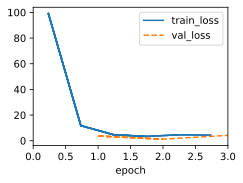

In [17]:
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
model = LinearRegressAbsLoss(2, lr=0.01)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)
model.w,model.b

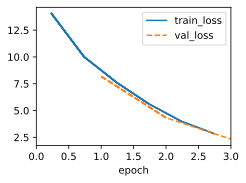

In [19]:
model = d2l.LinearRegressScratch(2, lr=0.01)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

### Check whether there is a difference in behavior if you actively perturb some entries, such as $y_5=10000$ of $y$

When perturbing entry y[5] to a large value, you'll notice that the squared loss reacts strongly to the perturbation, leading to a much larger value compared to the absolute value loss. This is because squared loss is more sensitive to outliers.

(tensor([[-50.7932],
         [344.7570]], requires_grad=True),
 tensor([4.0400], requires_grad=True))

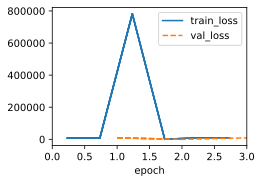

In [23]:
alpha = 10000/data.y[5]
data.X[5] *= alpha
data.y[5] = 10000
model = LinearRegressAbsLoss(2, lr=0.01)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)
model.w,model.b

(tensor([[nan],
         [nan]], requires_grad=True),
 tensor([nan], requires_grad=True))

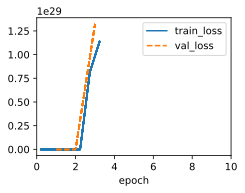

In [25]:
model = d2l.LinearRegressScratch(2, lr=0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
model.w,model.b

### Can you think of a cheap solution for combining the best aspects of squared loss and absolute value loss? Hint: how can you avoid really large gradient values?

To combine the best aspects of squared loss and absolute value loss while avoiding really large gradient values, you can consider using the Huber loss (also known as smooth L1 loss), which behaves like the squared loss near zero but transitions to the absolute value loss for larger values. This can provide a compromise between the two loss functions, preventing extreme gradients while being robust to outliers. 

In [37]:
class LineRegressionHuberLoss(d2l.Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs,1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)
        
    def forward(self, X):
        return torch.matmul(X, self.w) + self.b
    
    def loss(self, y_hat, y, sigma=1):
        beta = 1.0/(sigma**2)
        diff = torch.abs(y_hat - y)
        l = torch.where(diff<beta, 0.5*diff**2/beta, diff - 0.5*beta)
        return l.sum()
        
    def configure_optimizers(self):
        return d2l.SGD([self.w, self.b], self.lr)

(tensor([[ 0.0104],
         [-0.0376]], requires_grad=True),
 tensor([0.0007], requires_grad=True))

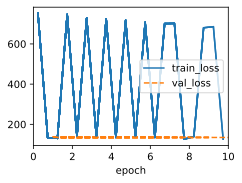

In [43]:
model = LineRegressionHuberLoss(2, lr=1e-7)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
model.w,model.b

## 9. Why do we need to reshuffle the dataset? Can you design a case where a maliciously constructed dataset would break the optimization algorithm otherwise?

Shuffling the dataset during training is important for improving the efficiency and effectiveness of optimization algorithms, particularly stochastic gradient descent (SGD) and its variants. Shuffling serves several purposes:

1. **Randomization:** Shuffling the dataset before each epoch ensures that the model encounters the data in a random order. This randomization helps prevent the model from memorizing the order of examples, which could lead to overfitting and biased learning.

2. **Smooth Convergence:** Shuffling reduces the chances of encountering clusters of similar examples together. If the dataset has some inherent order or structure, not shuffling could cause the optimization process to converge unevenly or slowly.

3. **Effective Exploration:** Shuffling encourages the optimization algorithm to explore different parts of the loss landscape in each epoch. This can help the model escape local minima and reach a more optimal solution.

Regarding a case where a maliciously constructed dataset could break the optimization algorithm, consider a scenario where the dataset is intentionally ordered in a way that exploits the optimization algorithm's weaknesses:

Imagine a dataset with examples sorted in a manner that gradually increases the loss. For instance, the dataset contains images of cats, and the images are ordered in such a way that the difficulty of classification gradually increases. If the optimization algorithm is used without shuffling, it would first encounter a series of easy examples, leading to quick convergence. However, as it proceeds, it would encounter progressively harder examples, causing the optimization algorithm to slow down, potentially getting stuck in suboptimal regions of the loss landscape.

In such a case, shuffling the dataset before each epoch would disrupt the ordered pattern and ensure that the optimization algorithm encounters examples of varying difficulty levels throughout training. This randomness helps the optimization process explore the loss landscape more effectively and prevents the algorithm from being misled by the malicious ordering.

Overall, shuffling the dataset is a common practice to improve the robustness and convergence of optimization algorithms in machine learning and deep learning tasks.